In [3]:
import os
import cv2
import time
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [4]:
data = pd.read_csv('/Users/yuhaining/Desktop/FacialExpressionClassification/data/fer2013.csv')
print(data.shape)
data.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


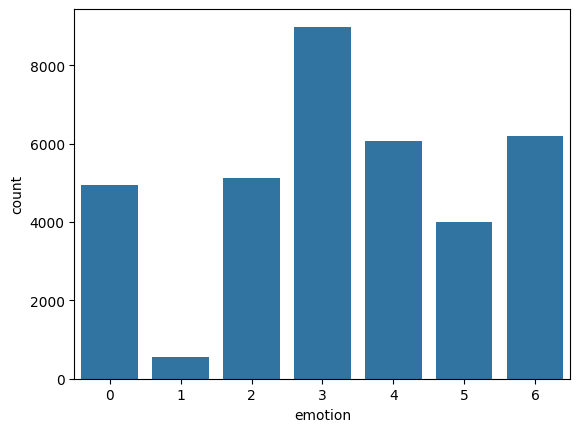

In [5]:
CLASSES = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

data.emotion.value_counts()
sns.countplot(x=data['emotion'])
plt.show()

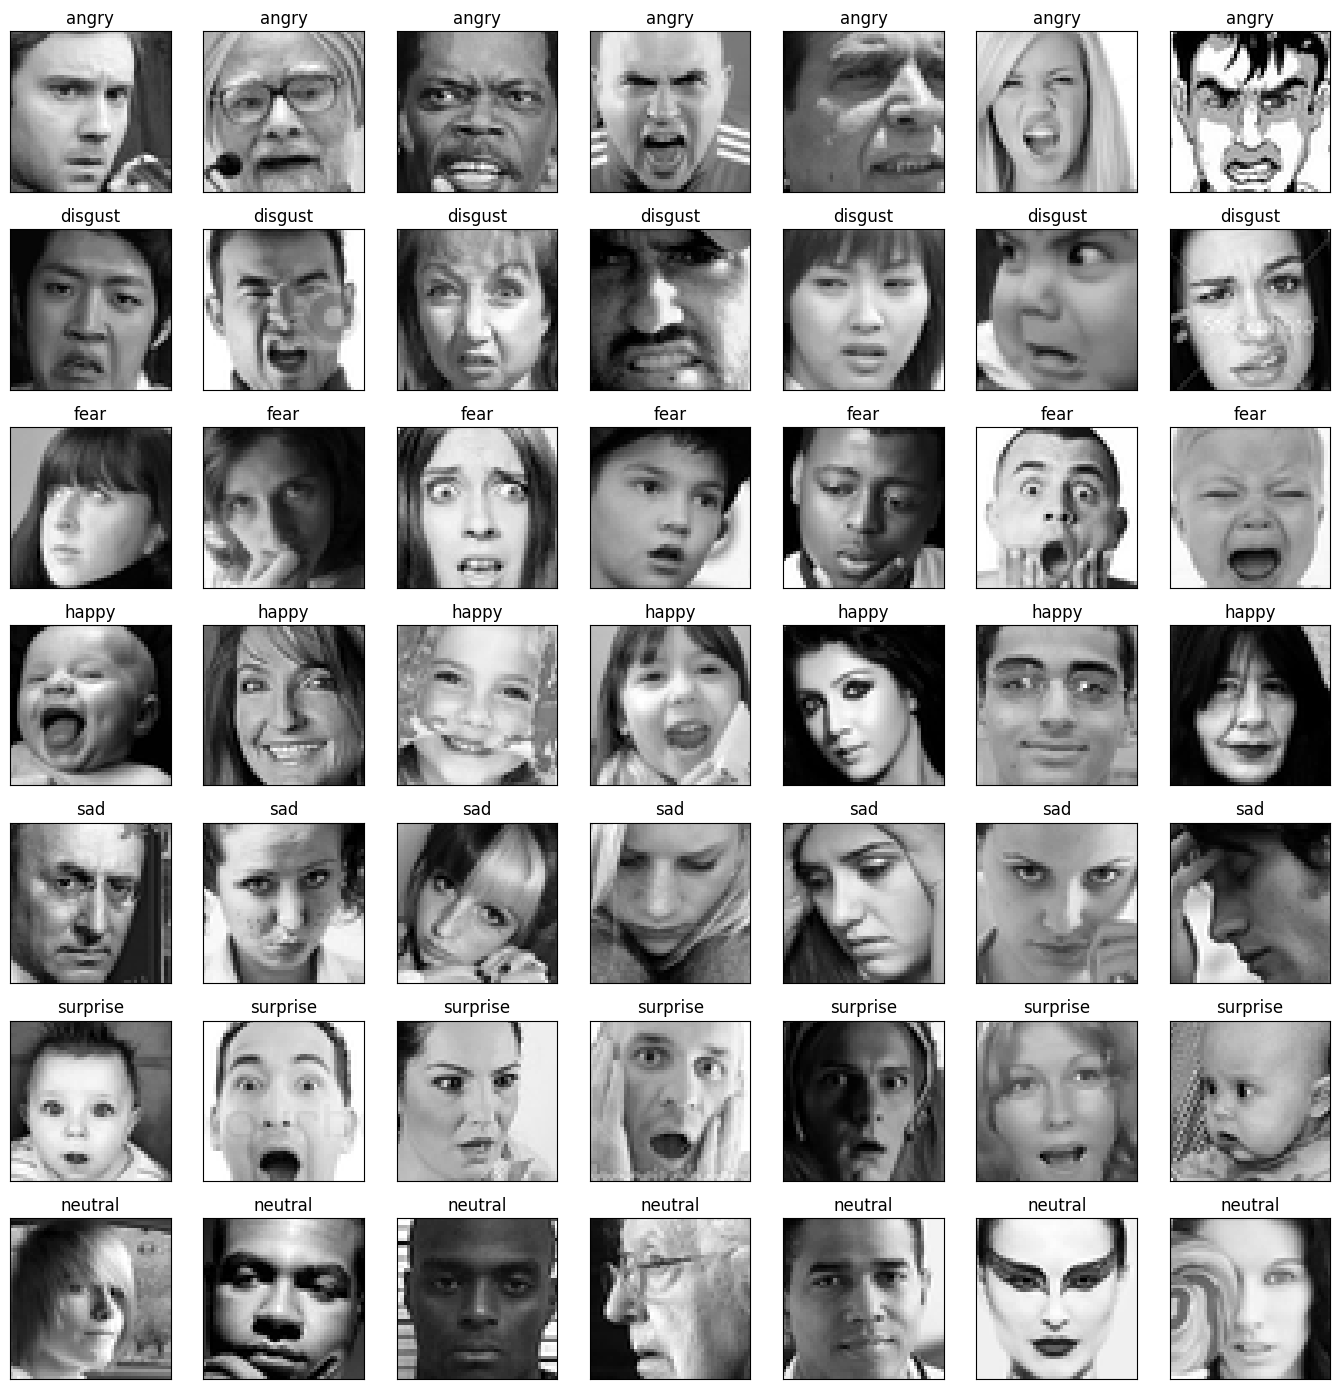

In [6]:
figure = pyplot.figure(1, figsize=(14,14))

k = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')

        k += 1
        ax = pyplot.subplot(7,7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(CLASSES[label])
        pyplot.tight_layout()


In [7]:
image_array = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float32'))
image_array = np.stack(image_array, axis=0)
image_array.shape

(35887, 48, 48, 1)

In [8]:
image_labels = data['emotion'].values
image_labels.shape

(35887,)

In [9]:
image_array = data.pixels.apply(
    lambda x: np.array(x.split(' ')).reshape(48,48).astype('uint8')
)
image_array = np.stack(image_array, axis=0)
image_array.shape

(35887, 48, 48)

In [10]:

X_train, X_test, y_train, y_test = train_test_split(
    image_array, 
    image_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=image_labels,
    shuffle=True
    )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28709, 48, 48), (7178, 48, 48), (28709,), (7178,))

In [11]:
for i in range(X_train.shape[0]):
    X_train[i] = cv2.equalizeHist(X_train[i])
    X_train[i] = cv2.GaussianBlur(X_train[i], (3,3), 0)
    X_train[i] = cv2.convertScaleAbs(X_train[i], alpha=1.3, beta=0)

for i in range(X_test.shape[0]):
    X_test[i] = cv2.equalizeHist(X_test[i])
    X_test[i] = cv2.GaussianBlur(X_test[i], (3,3), 0)
    X_test[i] = cv2.convertScaleAbs(X_test[i], alpha=1.3, beta=0)

In [12]:
height, width = (48, 48)
FEATURES = []
P = 8
R = 1
LBP_Method = 'uniform'
block_size = (8,8)
block_height = height // block_size[0]
block_width = width // block_size[1]
n_bins = P + 2 if LBP_Method == 'uniform' else 2 ** P


for i in range(X_train.shape[0]):
    img_features = []
    for j in range(block_size[0]):
        for k in range(block_size[1]):
            start_j = j * block_height
            end_j = start_j + block_height
            start_k = k * block_width
            end_k = start_k + block_width
            block = X_train[i][start_j:end_j, start_k:end_k]
            
            lbp = local_binary_pattern(block, P, R, method=LBP_Method)
            hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
            img_features.extend(hist)


    FEATURES.append(img_features)

FEATURES = np.array(FEATURES, dtype=np.float32)
print("LBP features shape:", FEATURES.shape)

LBP features shape: (28709, 640)


In [13]:
FEATURES_test = []
for i in range(X_test.shape[0]):
    img_features = []
    for j in range(block_size[0]):
        for k in range(block_size[1]):
            start_j = j * block_height
            end_j = start_j + block_height
            start_k = k * block_width
            end_k = start_k + block_width
            block = X_test[i][start_j:end_j, start_k:end_k]
            
            lbp = local_binary_pattern(block, P, R, method=LBP_Method)
            hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
            img_features.extend(hist)


    FEATURES_test.append(img_features)

FEATURES_test = np.array(FEATURES_test, dtype=np.float32)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(FEATURES)
Y_train = y_train

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}
knn = KNeighborsClassifier()

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, Y_train)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.397645041128995


Test Accuracy: 0.41641125661744216
Classification Report:
              precision    recall  f1-score   support

       angry       0.38      0.29      0.33       991
     disgust       0.41      0.29      0.34       109
        fear       0.38      0.30      0.33      1024
       happy       0.49      0.58      0.53      1798
         sad       0.38      0.26      0.31      1216
    surprise       0.44      0.57      0.50       800
     neutral       0.35      0.44      0.39      1240

    accuracy                           0.42      7178
   macro avg       0.40      0.39      0.39      7178
weighted avg       0.41      0.42      0.41      7178



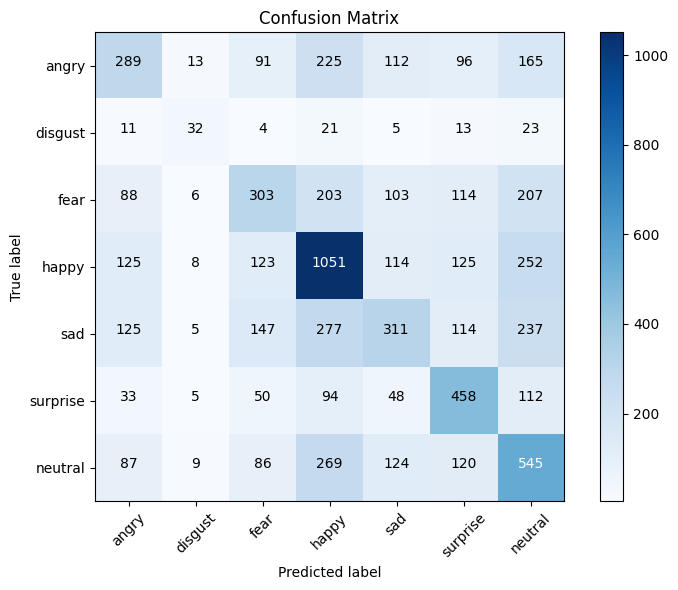

In [15]:
model = grid_search.best_estimator_
X_test_scaled = scaler.transform(FEATURES_test)
Y_test = y_test
Y_pred = model.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(Y_test, Y_pred))
print("Classification Report:")
print(classification_report(Y_test, Y_pred, target_names=CLASSES))

conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [16]:
_ = model.predict(X_test_scaled[:10])

start = time.perf_counter()
Y_pred = model.predict(X_test_scaled)
end = time.perf_counter()

total_time = end - start
avg_latency = total_time / len(X_test_scaled)

print(f"Total inference time (KNN only): {total_time:.4f} s")
print(f"Average latency per image (KNN only): {avg_latency*1000:.4f} ms")

Total inference time (KNN only): 5.7270 s
Average latency per image (KNN only): 0.7979 ms


In [17]:
BASE_DIR = os.getcwd()
joblib.dump(model, os.path.join(BASE_DIR, 'knn_lbp_model.joblib'))
joblib.dump(scaler, os.path.join(BASE_DIR, 'scaler_lbp.joblib'))

['/Users/yuhaining/Desktop/FacialExpressionClassification/Model/scaler_lbp.joblib']

In [18]:
hog_features = []
Orientation = 9
Pixels = (8, 8)
Cells = (2, 2)

for i in range(X_train.shape[0]):
    hog_feature = hog(X_train[i],
                      orientations=Orientation,
                      pixels_per_cell=Pixels,
                      cells_per_block=Cells,
                      block_norm='L2-Hys',
                      visualize=False,
                      channel_axis=None)
    hog_features.append(hog_feature)

hog_features = np.array(hog_features, dtype=np.float32)
print("HOG features shape:", hog_features.shape)    

HOG features shape: (28709, 900)


In [19]:
hog_features_test = []
for i in range(X_test.shape[0]):
    hog_feature = hog(X_test[i],
                      orientations=Orientation,
                      pixels_per_cell=Pixels,
                      cells_per_block=Cells,
                      block_norm='L2-Hys',
                      visualize=False,
                      channel_axis=None)
    hog_features_test.append(hog_feature)   
hog_features_test = np.array(hog_features_test, dtype=np.float32)
print("HOG test features shape:", hog_features_test.shape)

HOG test features shape: (7178, 900)


In [20]:
scaler_hog = StandardScaler()
X_train_hog_scaled = scaler_hog.fit_transform(hog_features)
Y_train_hog = y_train

param_grid_svm = {'C': [0.1, 1, 10, 100]}
svm = LinearSVC()

cv_strategy_svm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=cv_strategy_svm, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train_hog_scaled, Y_train_hog)
print("Best Hyperparameters for SVM:", grid_search_svm.best_params_)
print("Best Cross-Validation Accuracy for SVM:", grid_search_svm.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters for SVM: {'C': 0.1}
Best Cross-Validation Accuracy for SVM: 0.40548244428560853


SVM Test Accuracy: 0.41641125661744216
SVM Classification Report:
              precision    recall  f1-score   support

       angry       0.37      0.26      0.31       991
     disgust       0.29      0.17      0.21       109
        fear       0.32      0.17      0.22      1024
       happy       0.49      0.76      0.60      1798
         sad       0.32      0.24      0.27      1216
    surprise       0.43      0.50      0.47       800
     neutral       0.39      0.39      0.39      1240

    accuracy                           0.42      7178
   macro avg       0.37      0.36      0.35      7178
weighted avg       0.39      0.42      0.39      7178



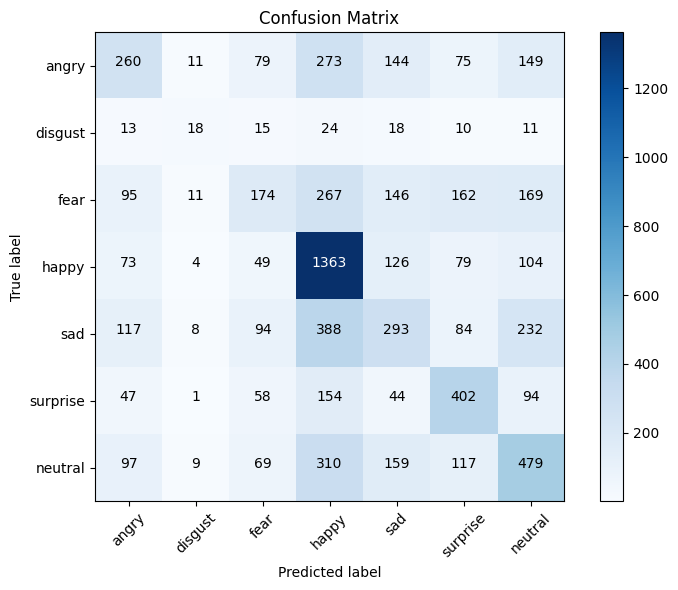

In [21]:
SVM_model = grid_search_svm.best_estimator_
X_test_hog_scaled = scaler_hog.transform(hog_features_test)
Y_test_hog = y_test
Y_pred_svm = SVM_model.predict(X_test_hog_scaled)
print("SVM Test Accuracy:", accuracy_score(Y_test_hog, Y_pred_svm))
print("SVM Classification Report:")
print(classification_report(Y_test_hog, Y_pred_svm, target_names=CLASSES))

conf_matrix_svm = confusion_matrix(Y_test_hog, Y_pred_svm)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_svm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)

thresh = conf_matrix_svm.max() / 2.
for i in range(conf_matrix_svm.shape[0]):
    for j in range(conf_matrix_svm.shape[1]):
        plt.text(j, i, format(conf_matrix_svm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_svm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [22]:
_ = SVM_model.predict(X_test_hog_scaled[:10])

start = time.perf_counter()
Y_pred_svm = SVM_model.predict(X_test_hog_scaled)
end = time.perf_counter()

total_time_svm = end - start
avg_latency_svm = total_time_svm / len(X_test_hog_scaled)

print(f"SVM Total inference time: {total_time_svm:.4f} s")
print(f"SVM Average latency per image: {avg_latency_svm*1000:.4f} ms")

SVM Total inference time: 0.0727 s
SVM Average latency per image: 0.0101 ms


In [23]:
joblib.dump(SVM_model, os.path.join(BASE_DIR, 'svm_hog_model.joblib'))
joblib.dump(scaler_hog, os.path.join(BASE_DIR, 'scaler_hog.joblib'))

['/Users/yuhaining/Desktop/FacialExpressionClassification/Model/scaler_hog.joblib']